# Titanic Survival- Binary Classification 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn import preprocessing


## Data Exploration



In [2]:
training_data= pd.read_csv('training.csv')
training_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
training_data.shape

(891, 12)

In [4]:
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test_data= pd.read_csv('testing.csv')
test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [6]:
test_data.shape

(418, 11)

In [7]:
#I want to check if I should merge columns 'Parch' and 'Sblings' into one 
training_data['is_alone']= pd.Series([1 if (row['Parch']!=0 or row['SibSp']!=0) else 0 for index, row in training_data.iterrows()], index= training_data.index)
test_data['is_alone']= pd.Series([1 if (row['Parch']!=0 or row['SibSp']!=0) else 0 for index, row in test_data.iterrows()], index= test_data.index)



In [8]:
numeric_features = ['Age', 'Fare']
ordinal_features = ['Pclass', 'SibSp', 'Parch']
nominal_features = ['Sex', 'Embarked', 'is_alone']

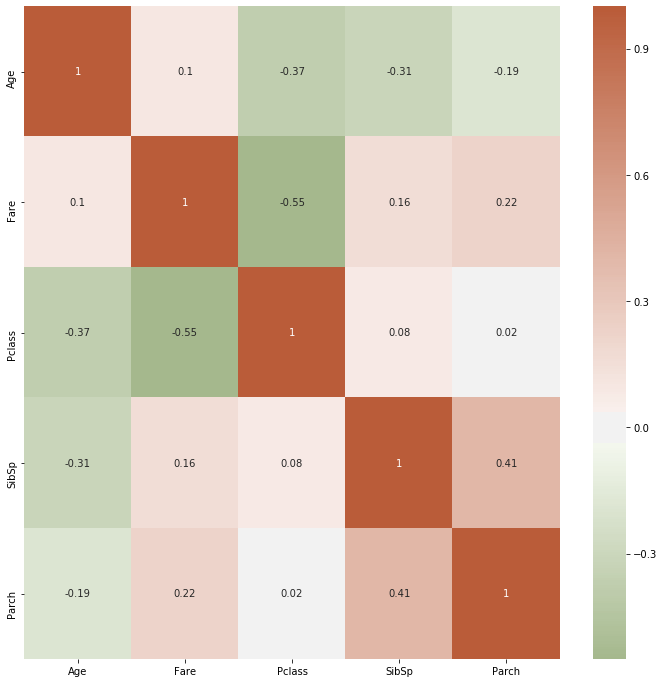

In [9]:
cor_matrix = training_data[numeric_features + ordinal_features].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(12,12));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(110, 24, as_cmap=True), ax=plt.subplot(111));
plt.show()

## Impute missing values

In [10]:
training_data['title'] = [i.split(",")[1].split(".")[0].strip() for i in training_data["Name"]]
test_data['title'] = [i.split(",")[1].split(".")[0].strip() for i in test_data["Name"]]
Y_train = training_data["Survived"].astype(int)
training_data.drop(columns='Survived', inplace=True)
dataset= pd.concat([training_data, test_data])
dataset_ages= dataset.groupby('title')['Age'].mean()


In [11]:
dataset_ages= dataset_ages.reset_index()
dataset_ages= dict(zip(dataset_ages['title'].values.tolist(), dataset_ages['Age'].values.tolist()))

        

In [12]:
new_age=[]
import math 
for index, row in dataset.iterrows():
    
    if math.isnan(row['Age']):
        new_age.append(dataset_ages[row['title']])
    else:
        new_age.append(row['Age'])


In [13]:
dataset.drop(columns= 'Age', inplace=True)
dataset['Age']= pd.Series(new_age, index= dataset.index)
training_data= dataset[:891]
test_data=dataset[891:]


# Classifiers 

SVC:

In [14]:
cross_validation = []
kfold = StratifiedKFold(n_splits=10)
random_state=2


In [15]:

X_train=training_data[numeric_features + ordinal_features + nominal_features]
X_train= X_train.fillna(0)
#need to encode nominal features as numeric features


#X_train['Embarked'].drop_duplicates()
nominal= X_train[nominal_features]

nominal['Embarked'] = nominal['Embarked'].map({0: 0, 'S':1, 'C': 2, 'Q': 3})
nominal['Sex'] = nominal['Sex'].map({'female': 1, 'male':0})

enc = preprocessing.OneHotEncoder(categories='auto')
enc.fit(nominal)
onehotlabels = enc.transform(nominal).toarray()

columns= ['Male', 'Female', 'S', 'C', 'Q','NA', 'alone', 'not_alone']
df= pd.DataFrame(onehotlabels, columns= columns)
X_train.drop(columns=nominal_features, inplace=True)
X_train = X_train.join(df, how='outer')
svm= SVC(random_state=random_state)
svm.fit(X_train, Y_train)
X_train

C:\Users\kdami\Anaconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\kdami\Anaconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kdami\Anaconda3\envs\titanic\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to acc

,Age,Fare,Pclass,SibSp,Parch,Male,Female,S,C,Q,NA,alone,not_alone
0,22.000000,7.2500,3,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,38.000000,71.2833,1,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,26.000000,7.9250,3,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,35.000000,53.1000,1,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.000000,8.0500,3,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,13.0000,2,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,19.000000,30.0000,1,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
888,21.774238,23.4500,3,1,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
889,26.000000,30.0000,1,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [16]:
X_test=test_data[numeric_features + ordinal_features + nominal_features]
X_test= X_test.fillna(0)
#need to encode nominal features as numeric features


#X_train['Embarked'].drop_duplicates()
nominal= X_test[nominal_features]

nominal['Embarked'] = nominal['Embarked'].map({0: 0, 'S':1, 'C': 2, 'Q': 3})
nominal['Sex'] = nominal['Sex'].map({'female': 1, 'male':0})

enc = preprocessing.OneHotEncoder(categories='auto')

enc.fit(nominal)
onehotlabels = enc.transform(nominal).toarray()

columns= ['Male', 'Female', 'S', 'C', 'Q', 'alone', 'not_alone']
onehotlabels.shape
df= pd.DataFrame(onehotlabels, columns= columns)
X_test.drop(columns=nominal_features, inplace=True)
X_test = X_test.join(df, how='outer')
X_test['NA']= 0.0

X_test= X_test[X_test.columns[:10].tolist()+ ['NA'] + X_test.columns[10:12].tolist()]
X_test


C:\Users\kdami\Anaconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\kdami\Anaconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Age,Fare,Pclass,SibSp,Parch,Male,Female,S,C,Q,NA,alone,not_alone
0,34.500000,7.8292,3,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,47.000000,7.0000,3,1,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,62.000000,9.6875,2,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,27.000000,8.6625,3,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,22.000000,12.2875,3,1,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,32.252151,8.0500,3,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
414,39.000000,108.9000,1,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
415,38.500000,7.2500,3,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
416,32.252151,8.0500,3,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
#prediction
predictions= svm.predict(X_test)
cross_val_score(svm, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

array([0.7       , 0.68888889, 0.74157303, 0.71910112, 0.74157303,
       0.70786517, 0.76404494, 0.78651685, 0.76404494, 0.79545455])